In [2]:
import sys
print sys.path

import psycopg2 as ppg

con = ppg.connect("dbname=tweets user=patrick")
print con

['', '/home/patrick/anaconda/lib/python27.zip', '/home/patrick/anaconda/lib/python2.7', '/home/patrick/anaconda/lib/python2.7/plat-linux2', '/home/patrick/anaconda/lib/python2.7/lib-tk', '/home/patrick/anaconda/lib/python2.7/lib-old', '/home/patrick/anaconda/lib/python2.7/lib-dynload', '/home/patrick/anaconda/lib/python2.7/site-packages', '/home/patrick/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-linux-x86_64.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/setuptools-17.0-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/IPython/extensions']
<connection object at 0x7f912c0ce168; dsn: 'dbname=tweets user=patrick', closed: 0>


In [3]:
#cur = con.cursor()
#cur.execute("SELECT tweet_id FROM tweets;")
#tweet_id = set(zip(*cur.fetchall())[0])
#cur.close()

Populating the interactive namespace from numpy and matplotlib
freq    253179
dtype: int64


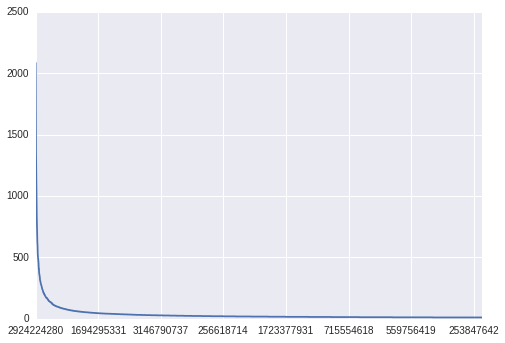

In [3]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

with con.cursor() as cur:
    cur.execute("SELECT user_id FROM tweets;")
    users = zip(*cur.fetchall())[0]

user_counts = pd.DataFrame({ 'freq': pd.Series(users).value_counts() })
user_counts[user_counts.freq>10].freq.plot()
print user_counts[user_counts.freq>10].sum()

In [5]:
# with con.cursor() as cur:
#     cur.execute("SELECT tweet_id, user_id, in_reply_to_tweet_id FROM tweets")
#     tweets_list = cur.fetchall()
# tweets = pd.DataFrame(tweets_list, columns=['tweet_id','user_id','reply_id']).set_index('tweet_id')
# %timeit replied_to = tweets[tweets.reply_id != 'None'].reply_id.values
# tweet_ids = set(tweets.index)
# %timeit questions = tweets[[twid in replied_to for twid in tweet_ids]]
# print questions

In [6]:
# replies = tweets[tweets.reply_id != 'None']
# hanging_questions= pd.Series([rid for rid in replies.reply_id if rid not in questions.tweet_id.values])
# print hanging_questions

Base rate of @-mentions
Base rate of in-reply-to's
Find variation across users in in-reply-to's/total num. tweets
Ratio by user of outgoing @mention rate to in-reply-to (to all that user's tweets)

In [64]:
# # annotate tweets with initial @mention rate
# at_ment_re = re.compile(r"^\s+\.?@")
# tweets['at_mention'] = tweets.text.apply(lambda x:
#      at_ment_re.search(x) is not None)
                                         

# users_grps = tweets.groupby('user_id')
# users_df = users_grps.apply(lambda x: pd.DataFrame({'num_at_out': x.at_mention.sum(),
#                                                     'num_at_in': 
#reload(seaborn)
con.rollback()

In [36]:
# Explore geotags
usa = (-125.6791025,25.4180700649,-66.885417,
                           49.3284551525)    
with con.cursor() as cur:
    cur.execute("SELECT tw.tweet_id, tw.user_id, tw.lat, tw.long, user_locs.place, plcs.place_lat, "
                "plcs.place_long "
                "FROM tweets as tw, (SELECT user_id, place FROM users) as user_locs, "
                "(SELECT place, coded_lat as place_lat, coded_long as place_long FROM "
                "places) as plcs "
                "WHERE tw.user_id = user_locs.user_id and user_locs.place != 'None' "
                "and plcs.place = user_locs.place AND plcs.place_lat != -500 AND "
                "plcs.place_long != 500 AND (user_locs.place ~* '[A-Z\s]+,\s*[A-Z]+' OR "
                "user_locs.place ~* '(New York City|NYC|LA|Los Angeles|Chicago|DC|SF|San Francisco|"
                "Detroit|Houston|Dallas|Atlanta|Philly|Philadelphia|Phoenix|San Antonio| "
                "San Jose|Austin|Jacksonville|Indianapolis|Denver)');")
    geotags = pd.DataFrame(cur.fetchall(), 
                       columns=["tweet_id","user_id","tweet_lat","tweet_long","user_location",
                               "user_lat", "user_long"])
    in_us = pd.Series((geotags['tweet_long'] > usa[0]) & (geotags['tweet_long'] < usa[2]) &
                        (geotags['tweet_lat'] > usa[1]) & (geotags['tweet_lat'] < usa[3]))
    print in_us
    geotags['in_us'] = in_us
    # look at distance between user location and tweet location
 
    geotags['tweet_distance'] = np.sqrt((geotags.user_lat - geotags.tweet_lat) ** 2 + 
                                        (geotags.user_long - geotags.tweet_long) ** 2)
    geotags['on_road'] = geotags['tweet_distance'] > 0.5
    
    # get number of users w/ any on-road tweets, other per-user stats
    users_on_road=geotags.groupby('user_id').apply(lambda x: pd.Series([x.on_road.any(), x.on_road.sum(), x.shape[0]],
             index=['any_on_road','num_on_road','num_tweets_user'])).reset_index()
    geotags = geotags.merge(users_on_road, on='user_id')
    


0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
...
120844    True
120845    True
120846    True
120847    True
120848    True
120849    True
120850    True
120851    True
120852    True
120853    True
120854    True
120855    True
120856    True
120857    True
120858    True
Length: 120859, dtype: bool


In [34]:
print "Number NA user lat/long: " + str(geotags[['user_id', 'user_lat']].drop_duplicates().user_lat.isnull().sum())
print geotags.shape
geotags.head(10)

Number NA user lat/long: 0
(107093, 13)


,tweet_id,user_id,tweet_lat,tweet_long,user_location,user_lat,user_long,in_us,tweet_distance,on_road,any_on_road,num_on_road,num_tweets_user
0,608746340210728960,23472383,41.878114,-87.629798,"Chicago, IL",41.850026,-87.650049,True,0.034627,False,True,15,42
1,606563877677989888,23472383,41.165000,-87.878333,"Chicago, IL",41.850026,-87.650049,True,0.722063,True,True,15,42
2,606806975599353856,23472383,41.878114,-87.629798,"Chicago, IL",41.850026,-87.650049,True,0.034627,False,True,15,42
3,606830604638822401,23472383,41.721051,-87.739234,"Chicago, IL",41.850026,-87.650049,True,0.156808,False,True,15,42
4,606838481503936512,23472383,41.881777,-87.637146,"Chicago, IL",41.850026,-87.650049,True,0.034272,False,True,15,42
5,606532017992409088,23472383,41.291424,-87.420590,"Chicago, IL",41.850026,-87.650049,True,0.603894,True,True,15,42
6,608002566798966785,23472383,41.878114,-87.629798,"Chicago, IL",41.850026,-87.650049,True,0.034627,False,True,15,42
7,608018323154952192,23472383,41.878114,-87.629798,"Chicago, IL",41.850026,-87.650049,True,0.034627,False,True,15,42
8,608391298006044673,23472383,41.581209,-87.371148,"Chicago, IL",41.850026,-87.650049,True,0.387361,False,True,15,42
9,608343942543867904,23472383,41.593370,-87.346427,"Chicago, IL",41.850026,-87.650049,True,0.397566,False,True,15,42


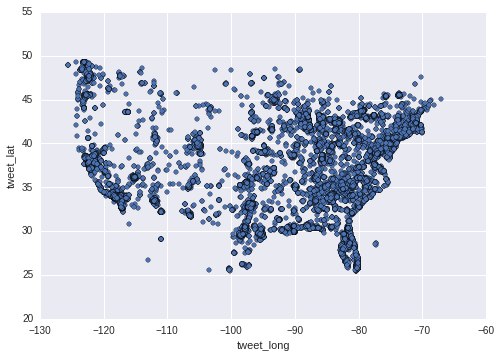

In [65]:
geotags[geotags['in_us']==True].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#LA

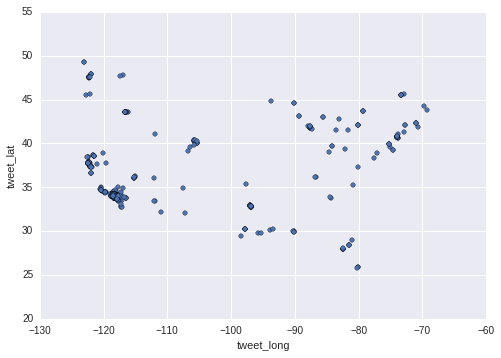

In [21]:
geotags[geotags['user_location']=="Los Angeles, CA"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#NYC

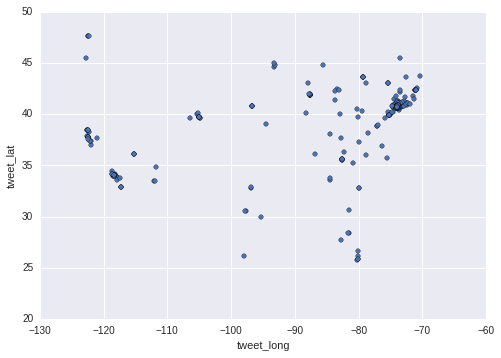

In [22]:
geotags[geotags['user_location']=="New York, NY"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

3                 Appleton, WI
4                Champaign, IL
13               New York City
14              Greenville, NC
27                    Chicago 
29                Indianapolis
30                  Albany, NY
32                 Seattle, WA
37                Arizona, USA
38    Pittsburgh, Pennsylvania
39         Boca Raton, Florida
41             California, USA
47                Columbia, MO
50                 Atlanta, GA
55                Philadelphia
...
90695                    Atlanta,GA
91078                   Boston, MA 
91911    Philadelphia, Pennsylvania
92507                Abilene, Texas
93387                San Antonio,TX
95249                Sioux City, IA
95256              Bozeman, Montana
95550            Fresno, California
96239            Hermosillo, Sonora
96247                   Compton, CA
96863                   Bozeman, MT
97353                  Buffalo, NY 
97527               Vancouver, B.C.
97905            East Nashville, TN
98452                   orl

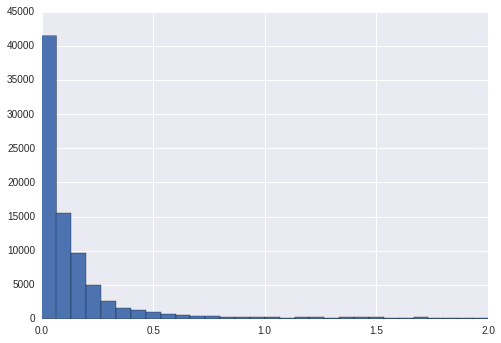

In [5]:
#print geotags.ix[np.argmax(geotags['tweet_distance'])]
#((geotags.user_lat - geotags.tweet_lat) ** 2).describe()
geotags[geotags.tweet_distance < 2].tweet_distance.hist(bins=30)
print geotags[geotags.tweet_distance > 0.5].user_location.drop_duplicates()


                 tweet_id   user_id  tweet_lat  tweet_long  user_location  \
41311  606583951956799489  52736858  32.743888 -117.160563  New York City   
41312  606587057926979584  52736858  32.735594 -117.149853  New York City   
41313  606587591358562304  52736858  32.735594 -117.149853  New York City   

        user_lat  user_long in_us  tweet_distance on_road any_on_road  \
41311  40.714269 -74.005968  True       43.884462    True        True   
41312  40.714269 -74.005968  True       43.875438    True        True   
41313  40.714269 -74.005968  True       43.875438    True        True   

       num_on_road  num_tweets_user  
41311            3                3  
41312            3                3  
41313            3                3  


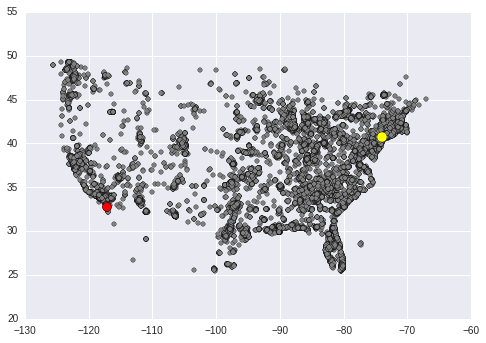

In [110]:
import random
plt.scatter(geotags[geotags['in_us']==True]['tweet_long'],geotags[geotags['in_us']==True]['tweet_lat'],
           c='gray')
# random user's home location
random_user = geotags.loc[random.sample(geotags[geotags.on_road].index, 1), 'user_id']


user_tweets = geotags[geotags['user_id']==random_user.values[0]]
print user_tweets
plt.scatter(user_tweets.tweet_long, user_tweets.tweet_lat,
            c='red', s=75)
plt.scatter(user_tweets.user_long.drop_duplicates(), user_tweets.user_lat.drop_duplicates(), 
            c='yellow',s=100)


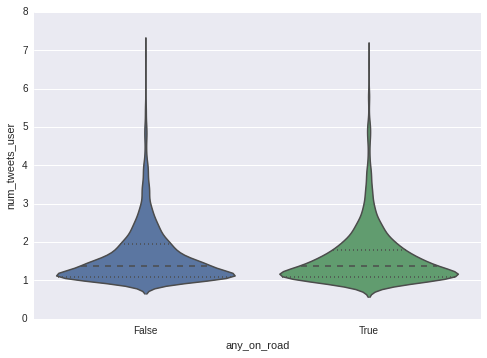

In [121]:
# compare number of tweets between on/off road
tweet_freqs = geotags[(geotags['num_tweets_user'] >= 3)][['user_id','num_tweets_user','any_on_road']]. \
    drop_duplicates()
#plt.axis([None, None, 0,5])

seaborn.violinplot(tweet_freqs.num_tweets_user.map(np.log), groupby=tweet_freqs.any_on_road)

In [25]:
# do logistic regression on topic features
with con.cursor() as cur:
    cur.execute("SELECT user_id, " +
               ', '.join(["topic_{}".format(x) for x in range(0,40)]) +
               " FROM users WHERE topic_0 is not NULL")
    topic_matrix = pd.DataFrame(cur.fetchall(), columns = ["user_id"] + 
                           ["topic_{}".format(x) for x in range(0,40)])
geotopics = topic_matrix.merge(geotags[['user_id','any_on_road']].drop_duplicates(), on='user_id', how='left')    

In [26]:
print geotopics.dropna().any_on_road.shape[0]
print geotopics.dropna().any_on_road.sum()

325
100


In [35]:
geotags[geotags['user_id']=='74998364']
#geotopics


,tweet_id,user_id,tweet_lat,tweet_long,user_location,user_lat,user_long,in_us,tweet_distance,on_road,any_on_road,num_on_road,num_tweets_user
